<a href="https://colab.research.google.com/github/josafamarengo/transfer-learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bibliotecas e módulos importados:
- **os:** fornece funções para interagir com o sistema operacional, por exemplo, manipulação de arquivos e diretórios.
- **random:** fornece funções para gerar números aleatórios.
- **tensorflow:** biblioteca de aprendizado de máquina de código aberto, usada para criar e treinar modelos de aprendizado de máquina.
- **tensorflow_datasets:** biblioteca que fornece conjuntos de dados prontos para uso em projetos de aprendizado de máquina.
- **numpy:** fornece ferramentas para trabalhar com matrizes e álgebra linear.
- **keras:** biblioteca de aprendizado de máquina de alto nível que pode ser usada em conjunto com TensorFlow para criar modelos de aprendizado de máquina.
- **matplotlib.pyplot:** biblioteca para visualização de dados em Python. Aqui, ele é usado para plotar imagens.
- **keras.preprocessing.image:** fornece ferramentas para processar imagens antes de alimentá-las aos modelos de aprendizado de máquina.
- **keras.applications.imagenet_utils:** fornece funções de utilidade para trabalhar com imagens no formato do conjunto de dados ImageNet.
- **keras.models.Sequential:** modelo de rede neural sequencial em Keras.
- **keras.layers:** fornece classes para adicionar camadas em uma rede neural em Keras.
- **keras.models.Model:** classe base para definir modelos de aprendizado de máquina em Keras.

In [2]:
import os
import random
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Baixa um conjunto de dados contendo imagens de gatos e cachorros e extrai o arquivo zipado. Em seguida, define as variáveis `train_dir` e `validation_dir`, que apontam para os diretórios de treinamento e validação do conjunto de dados. Por fim, define as variáveis `BATCH_SIZE` e `IMG_SIZE`, que determinam o tamanho do lote e o tamanho das imagens que serão usadas no treinamento do modelo, respectivamente.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE=1
IMG_SIZE = (160, 160)

68606236/68606236 [==============================] - 4s 0us/step


Define uma função `train_val_generators` que utiliza o módulo `ImageDataGenerator` do Keras/TensorFlow para criar geradores de dados de treinamento e validação a partir de um diretório de treinamento e um diretório de validação especificados como argumentos da função.

O `train_datagen` e `validation_datagen` normalizam as imagens por meio da divisão de cada pixel por 255, enquanto o `train_generator` e o `validation_generator` criam os conjuntos de dados de treinamento e validação por meio da função `image_dataset_from_directory`, que cria um conjunto de dados a partir das imagens presentes em um diretório.



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
 
  train_datagen = ImageDataGenerator(rescale=1.0/255.)
  train_generator = tf.keras.utils.image_dataset_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE, 
                                                      #class_mode='binary',
                                                      image_size=IMG_SIZE)

  validation_datagen = ImageDataGenerator(rescale=1.0/255.)
  validation_generator = tf.keras.utils.image_dataset_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE, 
                                                                #class_mode='binary',
                                                                image_size=IMG_SIZE)
  return train_generator, validation_generator

Cria geradores de dados de treinamento e validação, utilizando a função `train_val_generators` previamente definida. Esses geradores serão usados para alimentar o modelo de rede neural durante o treinamento e validação.

In [5]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [6]:
print(train_generator.class_names)

class_names = train_generator.class_names
num_classes=len(class_names)

['cats', 'dogs']


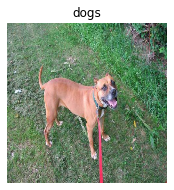

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

In [9]:
def normalizatiton_resize(train_ds):
  normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
  return normalized_ds


In [10]:
train_generator = normalizatiton_resize(train_generator)
image_batch, labels_batch = next(iter(train_generator))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(train_generator)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0074926186 1.0
<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [11]:
validation_generator = normalizatiton_resize(validation_generator)

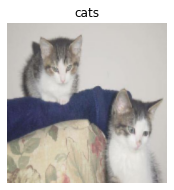

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in validation_generator.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()*255).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
# build the network
model = Sequential()
print("Input dimensions: ",(224, 224,3))


model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes*64))
model.add(Dense(2, activation='softmax'))


model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

In [14]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    batch_size=32,
                    epochs=10,
                    validation_data=validation_generator)


Epoch 1/10
2000/2000 [==============================] - 30s 10ms/step - loss: 0.7061 - accuracy: 0.4840 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/10
2000/2000 [==============================] - 19s 9ms/step - loss: 0.6961 - accuracy: 0.4910 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.6946 - accuracy: 0.4875 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
2000/2000 [==============================] - 18s 9ms/step - loss: 0.6949 - accuracy: 0.4880 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
2000/2000 [==============================] - 21s 10ms/step - loss: 0.6948 - accuracy: 0.4775 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
2000/2000 [==============================] - 20s 10ms/step - loss: 0.6939 - accuracy: 0.5020 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/10
2000/2000 [==============================] - 18s 9ms/step - loss: 0.6947 - accuracy: 0.4935 - val_loss: 0.6932 - va

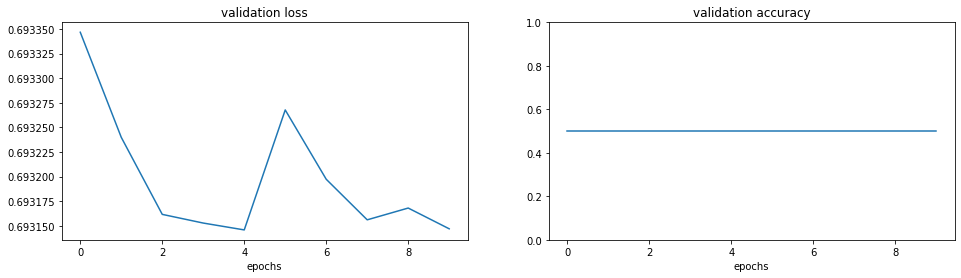

In [15]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [16]:
loss, accuracy = model.evaluate(validation_generator, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6931468844413757
Test accuracy: 0.5


In [17]:
vgg = keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [18]:
inp = vgg.input

mider=Dense(num_classes*128,activation='relu')(vgg.layers[-2].output)
new_classification_layer = Dense(num_classes, activation='softmax')(mider)

out = new_classification_layer

model_new = Model(inp, out)


In [19]:
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
history2 = model_new.fit(train_generator, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=validation_generator)

Epoch 1/10
2000/2000 [==============================] - 48s 23ms/step - loss: 0.5777 - accuracy: 0.6945 - val_loss: 0.4868 - val_accuracy: 0.7770
Epoch 2/10
2000/2000 [==============================] - 46s 23ms/step - loss: 0.4674 - accuracy: 0.7865 - val_loss: 0.4283 - val_accuracy: 0.8040
Epoch 3/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.4280 - accuracy: 0.8090 - val_loss: 0.4425 - val_accuracy: 0.7650
Epoch 4/10
2000/2000 [==============================] - 46s 23ms/step - loss: 0.4033 - accuracy: 0.8275 - val_loss: 0.4243 - val_accuracy: 0.7820
Epoch 5/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.3881 - accuracy: 0.8270 - val_loss: 0.3846 - val_accuracy: 0.8130
Epoch 6/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.3746 - accuracy: 0.8380 - val_loss: 0.3619 - val_accuracy: 0.8350
Epoch 7/10
2000/2000 [==============================] - 37s 19ms/step - loss: 0.3658 - accuracy: 0.8355 - val_loss: 0.4006 -

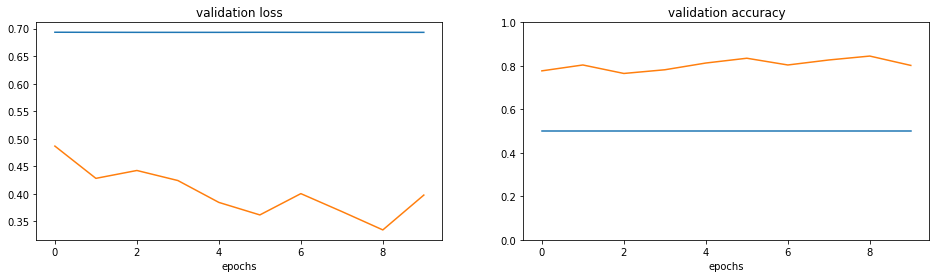

In [21]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [22]:
loss, accuracy = model_new.evaluate(validation_generator, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3979355990886688
Test accuracy: 0.8019999861717224
